In [92]:
import re
import random
import pandas as pd
import hashlib

In [93]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.1


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [94]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Developer Associate,532.270899,12.378393,36.788083,43
OData,770.443310,192.610827,294.966010,4
Python,1134.378506,24.135713,36.744264,47
Todd Ideas,1161.846553,77.456437,165.231411,15
Email Auth and Security,1597.600071,133.133339,494.604241,12
SharePoint,1866.451661,155.537638,595.584107,12
Audit Report Tracker (Sharepoint List),1999.108980,153.777614,388.985671,13
Azure Functions + Visual Studio,2160.435743,154.316839,498.713137,14
Debugging in VS Code,2227.882303,111.394115,278.861746,20
IW Migration,2334.716185,166.765442,478.945992,14


# Histogram

78744.79


<Axes: >

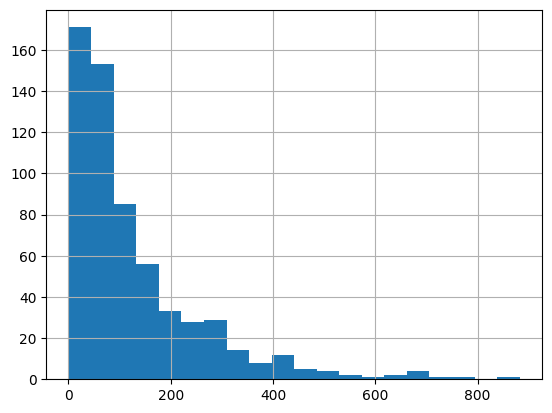

In [95]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [96]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [97]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [98]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [99]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [100]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [101]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [102]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [103]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [104]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 610


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
79,Azure AI Search,"After the first indexer run, you can rerun it ...",32962e9b2ebb8fe8f74b47cd3080634c,-747.023347,-286.713582,747.023347,4013.990153,0.555066,0,0
80,Azure AI Search,You can run indexers on demand or on a recurri...,d21f788db3aa4c9876a0cd1b9fc6575a,-410.019864,-286.713582,747.023347,4013.990153,0.555066,3,0
81,Azure AI Search,A search service runs one indexer job per sear...,8ced20f45d99f3695593df15dc3bb81b,-277.699078,-286.713582,747.023347,4013.990153,0.555066,6,0
82,Azure AI Search,Integrated vectorization is an extension of th...,fefb72f4e20a03e6f44b64672d721418,-122.571138,-286.713582,747.023347,4013.990153,0.555066,9,0
83,Azure AI Search,A quick way to perform a preliminary check on ...,9b368be497f64f7521778d6f8408af62,-71.225741,-286.713582,747.023347,4013.990153,0.555066,12,0
111,Azure Functions,2. Suppose your Azure Function has a blob trig...,fc5054fcf13b3189012cf676692c4f29,-766.205987,-279.846685,766.205987,3078.313538,0.335699,0,0
112,Azure Functions,Managed identities for Azure resources is the ...,d618a61eb92103d74592fcb5b08e7479,-318.640479,-279.846685,766.205987,3078.313538,0.335699,3,0
113,Azure Functions,Activity functions are the basic units of work...,64379cd90c412b46bfd075ad3219f0fe,-157.902186,-279.846685,766.205987,3078.313538,0.335699,6,0
114,Azure Functions,When you enable a system-assigned managed iden...,9023717ae86ade1f00495acbc7c511ab,-62.226995,-279.846685,766.205987,3078.313538,0.335699,9,0
99,DNS,Securing Zone Transfers\nMeasures taken to pro...,29d80ddfc54d4c7ce2121c00053c35cd,-423.016604,-213.806517,423.016604,3420.904275,0.649272,0,0


## Age Max

In [105]:
# n = 1
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [106]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [107]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [108]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
79,Azure AI Search,"After the first indexer run, you can rerun it ...",32962e9b2ebb8fe8f74b47cd3080634c,-747.023347,-286.713582,747.023347,4013.990153,0.555066,0,0
80,Azure AI Search,You can run indexers on demand or on a recurri...,d21f788db3aa4c9876a0cd1b9fc6575a,-410.019864,-286.713582,747.023347,4013.990153,0.555066,3,0
81,Azure AI Search,A search service runs one indexer job per sear...,8ced20f45d99f3695593df15dc3bb81b,-277.699078,-286.713582,747.023347,4013.990153,0.555066,6,0
82,Azure AI Search,Integrated vectorization is an extension of th...,fefb72f4e20a03e6f44b64672d721418,-122.571138,-286.713582,747.023347,4013.990153,0.555066,9,0
83,Azure AI Search,A quick way to perform a preliminary check on ...,9b368be497f64f7521778d6f8408af62,-71.225741,-286.713582,747.023347,4013.990153,0.555066,12,0
111,Azure Functions,2. Suppose your Azure Function has a blob trig...,fc5054fcf13b3189012cf676692c4f29,-766.205987,-279.846685,766.205987,3078.313538,0.335699,0,0
112,Azure Functions,Managed identities for Azure resources is the ...,d618a61eb92103d74592fcb5b08e7479,-318.640479,-279.846685,766.205987,3078.313538,0.335699,3,0
113,Azure Functions,Activity functions are the basic units of work...,64379cd90c412b46bfd075ad3219f0fe,-157.902186,-279.846685,766.205987,3078.313538,0.335699,6,0
114,Azure Functions,When you enable a system-assigned managed iden...,9023717ae86ade1f00495acbc7c511ab,-62.226995,-279.846685,766.205987,3078.313538,0.335699,9,0
99,DNS,Securing Zone Transfers\nMeasures taken to pro...,29d80ddfc54d4c7ce2121c00053c35cd,-423.016604,-213.806517,423.016604,3420.904275,0.649272,0,0


In [109]:
existing_cards['age'].mean()

-129.0898203200417